In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import theano.tensor as tt

# Are you convinced self-driving cars are safe?

A friend posed the following question: 

"In MA there were 0.52 fatalities/100 million miles driven. Since 2009 Google has driven ~1.5 million miles without a crash - does this convince you that self-driving cars are safe?"

I objected to the premise for a number of reasons:

- We're comparing a rate (0.52 fatalities/100mm) to a number (0 fatalities)
- Google probably drives in California, not Massachusetts

In searching for the California fatality rate, I found a beautiful data set that allowed me to essentially copy and paste the case study for hierarchical partial pooling from the <a href="http://docs.pymc.io/notebooks/hierarchical_partial_pooling.html">PyMC3 documentation</a> and the <a href="http://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html">Stan documentation</a>.  That study was estimating batting averages early in the season, and pooling over different players.  We will pool our data over the states, and change the response from a `Binomial` distribution (did the batter hit?) to a `Poisson` distribution (how many fatalities occured during the period?)

# Gathering Data

There's a page with a beautiful table, and a beautiful html reader in pandas, so this works.

In [3]:
import os
fatality_data = 'fatality_data.csv'

In [4]:
if not os.path.exists(fatality_data):
    df = pd.read_html('https://www.fhwa.dot.gov/ohim/onh00/onh2p11.htm')[0]
    df.columns = df.iloc[0]
    df = df.reindex(df.index.drop([0, 52]))  # also drop the aggregate row
    df.to_csv(fatality_data, index=False)
df = pd.read_csv(fatality_data)

In [5]:
# Pandas did not detect most columns as numeric, so we can cast them all here
df[df.columns[1:]] = df[df.columns[1:]].apply(pd.to_numeric)

# Extract the data we need as numpy arrays
miles_e6 = (df['Annual VMT (Millions)']).as_matrix()
fatalities = df['Total Highway Fatalities'].as_matrix()

# Build a hierarchical model

We assume that there is a distribution of fatality rates, and each state has a background rate drawn from there.  We really should model state-level effects more carefully before applying this pooling, but life is short.  We additionally assume that google's cars have a fatality rate drawn from the same distribution.  This is a prior we could argue over, but it seems reasonable, given our lack of other experiments with self driving cars.

Intuitively, $\phi$ is the probability of probabilities, and $\theta$ is a vector of length 51 (DC is a state?), with estimates for their own true fatality rates.  I model google's self-driving fatality rate as a separate variable, but in the same way, as $\theta_{\text{google}}$.

For what it is worth, I used the *exact* model from the PyMC3 documentation (with `y` being Binomial distributed instead of Poisson), and came to qualitatively the same conclusions.

In [6]:
def car_model(miles, fatalities, google_miles=1.5, google_fatalities=0):
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        κ_log = pm.Exponential('κ_log', lam=1.5)
        κ = pm.Deterministic('κ', tt.exp(κ_log))

        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*κ, 
                             beta=(1.0-pooled_rate)*κ, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=state_rate*miles, observed=fatalities)

        google_rate = pm.Beta('google_rate', 
                              alpha=pooled_rate*κ, 
                              beta=(1.0-pooled_rate)*κ)
        observed_google_fatalities = pm.Poisson('y_new', 
                                                mu=google_miles*google_rate, 
                                                observed=google_fatalities)
    return model

In [7]:
with car_model(miles_e6, fatalities):
    trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
100%|██████████| 10500/10500 [00:44<00:00, 236.50it/s]


# Interpreting the model

We drew four chains, and the chains look pretty identical, so seems like a good trace.

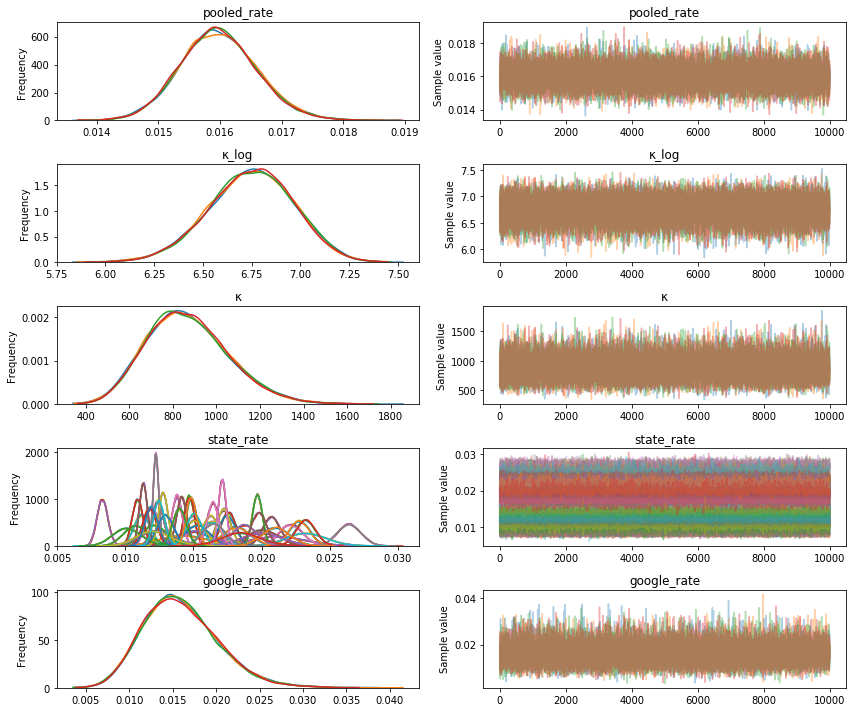

In [8]:
pm.traceplot(trace);

# Answering the question

The original question was whether I trust Google's self driving cars, given the fatality rate in MA.  I don't, yet.

In [9]:
plt.style.use('seaborn-talk')

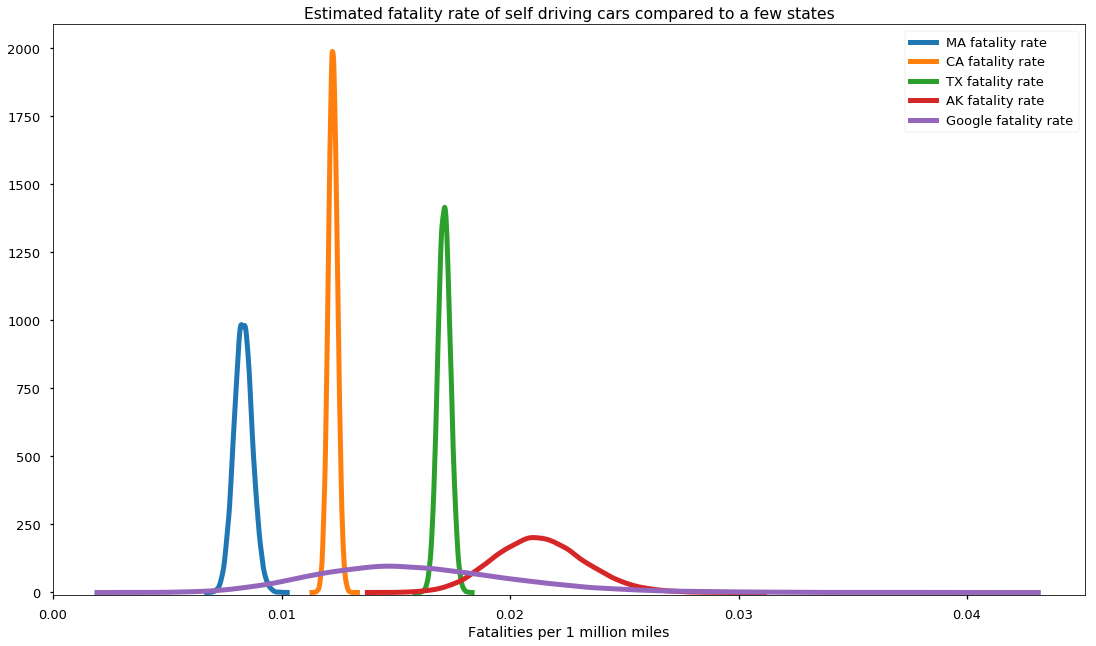

In [10]:
fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
for state in ('MA', 'CA', 'TX', 'AK'):
    sns.distplot(trace['state_rate'][:, df.State == state], label='{} fatality rate'.format(state), **shared_kwargs)
sns.distplot(trace['google_rate'], label='Google fatality rate', **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=-10)
ax.set_title('Estimated fatality rate of self driving cars compared to a few states')
ax.set_xlabel('Fatalities per 1 million miles')

ax.legend();

# Update!

As of November 28, 2017, <a href="https://www.theverge.com/2017/11/28/16709104/waymo-self-driving-autonomous-cars-public-roads-milestone">The Verge</a> reports that Waymo has driven 4 million miles.  How does that change our conclusions?  Not much!  This is reasonable, since the average state has 50 billion miles in the dataset, so moving from 1.5million to 4million should not change the inference very much.

In [11]:
with car_model(miles_e6, fatalities, google_miles=4.):
    updated_trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:34<00:00, 301.59it/s]
/Users/colin/anaconda3/envs/car_safety3.6/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.885059902267, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))


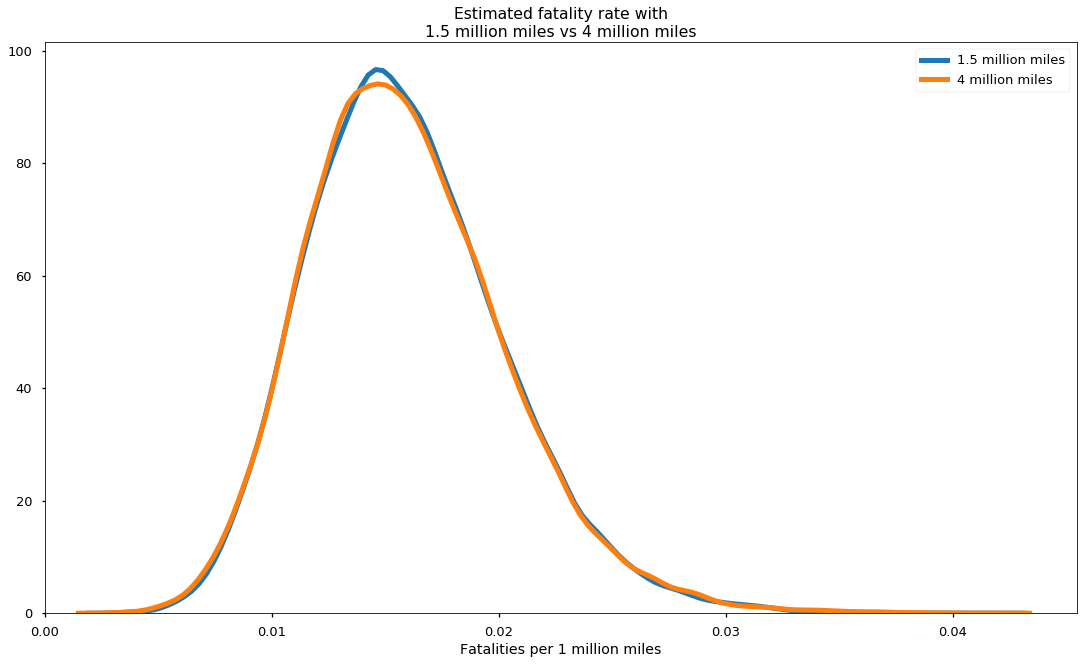

In [12]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
sns.distplot(trace['google_rate'], label='1.5 million miles', **shared_kwargs)
sns.distplot(updated_trace['google_rate'], label='4 million miles', **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_title('Estimated fatality rate with\n1.5 million miles vs 4 million miles')
ax.set_xlabel('Fatalities per 1 million miles')
ax.legend();

# Estimates of fatality rates in all 50 states, plus DC

These are interesting on their own, and I thought I would include it.

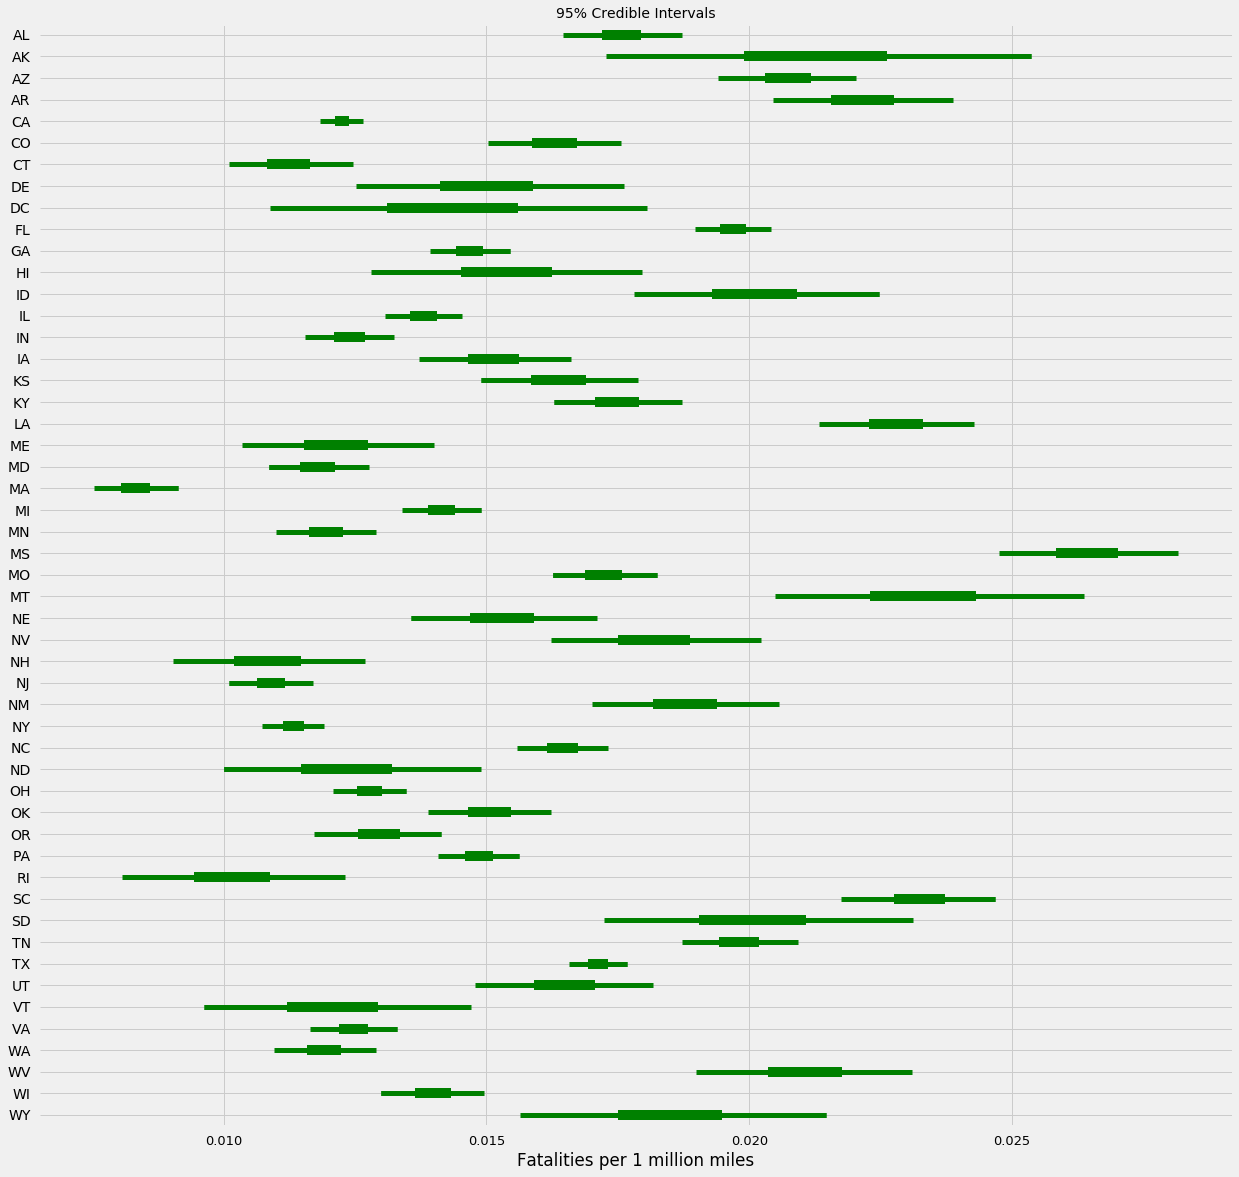

In [13]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18, 18)
plt.style.use('fivethirtyeight')
pm.forestplot(trace, ('state_rate',), 
              chain_spacing=0, 
              ylabels=df.State, 
              rhat=False, 
              xtitle="Fatalities per 1 million miles",
             plot_kwargs={"linewidth": 10, 'color': 'green'});